In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *
torch.set_num_threads(2)

## ConvNet

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs))

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,16, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(16,data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(AvgStatsCallback(accuracy))

In [13]:
%time run.fit(1, learn)

train: [2.20186, tensor(0.1866)]
valid: [1.8516697265625, tensor(0.3363)]
CPU times: user 6.11 s, sys: 4.09 s, total: 10.2 s
Wall time: 3.42 s


## CUDA

In [13]:
#export
class CudaCallback(Callback):
    def begin_fit(self, run): run.model.cuda()
    def begin_batch(self, run): run.xb,run.yb = run.xb.cuda(),run.yb.cuda()

In [14]:
model = get_cnn_model(data)

In [15]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner([AvgStatsCallback(accuracy), CudaCallback()])

In [17]:
%time run.fit(3, learn)

train: [2.250249375, tensor(0.1483, device='cuda:0')]
valid: [1.8449322265625, tensor(0.3548, device='cuda:0')]
train: [1.68084390625, tensor(0.4144, device='cuda:0')]
valid: [1.570175390625, tensor(0.4762, device='cuda:0')]
train: [1.044627421875, tensor(0.6583, device='cuda:0')]
valid: [0.636278662109375, tensor(0.7889, device='cuda:0')]
CPU times: user 3.53 s, sys: 806 ms, total: 4.34 s
Wall time: 4.25 s


## Refactor model

In [16]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [17]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self, run): run.xb = self.tfm(run.xb)

def resize_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

This model can now work on any size input:

In [18]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==1 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [19]:
def get_runner(model, lr=0.6, cbs=None, loss_func = F.cross_entropy):
    opt = optim.SGD(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner([AvgStatsCallback([accuracy]), CudaCallback(),
        BatchTransformXCallback(resize_tfm(1,28,28))] + listify(cbs))

In [20]:
nfs = [8,16,32,32]

In [21]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [24]:
run.fit(3, learn)

train: [2.1264459375, tensor(0.2616, device='cuda:0')]
valid: [1.581421484375, tensor(0.4090, device='cuda:0')]
train: [0.675396484375, tensor(0.7758, device='cuda:0')]
valid: [0.228989208984375, tensor(0.9329, device='cuda:0')]
train: [0.214808203125, tensor(0.9346, device='cuda:0')]
valid: [0.149219140625, tensor(0.9553, device='cuda:0')]


## Hooks

### Manual insertion

In [24]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.mean())
            self.act_stds [i].append(x.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [26]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, lr=0.5)

In [27]:
run.fit(2, learn)

train: [1.929164375, tensor(0.3298, device='cuda:0')]
valid: [0.999116796875, tensor(0.6664, device='cuda:0')]
train: [0.43132671875, tensor(0.8713, device='cuda:0')]
valid: [0.31305693359375, tensor(0.9029, device='cuda:0')]


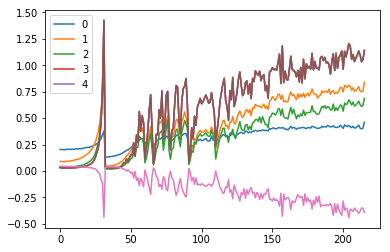

In [28]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

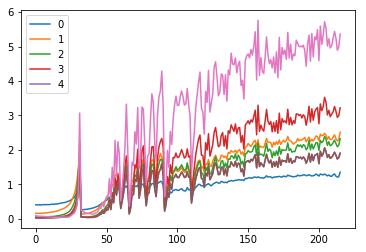

In [29]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

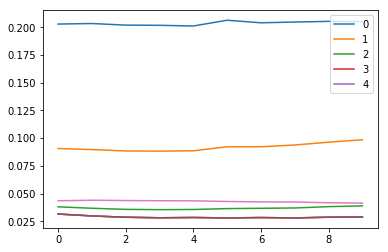

In [30]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(5));

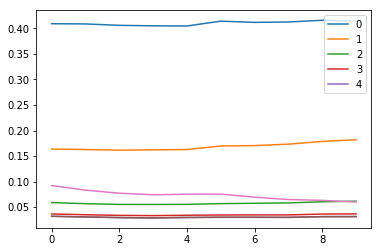

In [31]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(5));

### Pytorch hooks

In [32]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [33]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [34]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.mean())
    act_stds [i].append(outp.std())

In [35]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [36]:
run.fit(1, learn)

train: [2.21099625, tensor(0.2142, device='cuda:0')]
valid: [1.7994369140625, tensor(0.3337, device='cuda:0')]


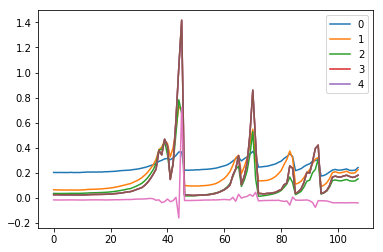

In [37]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

In [86]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.means = []
        self.stds  = []
        self.hook = m.register_forward_hook(partial(f, self))
        
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [87]:
def append_stats(hook, mod, inp, outp):
    hook.means.append(outp.mean())
    hook.stds .append(outp.std())

In [88]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, lr=0.5)

In [89]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [42]:
run.fit(1, learn)

train: [1.7160421875, tensor(0.4081, device='cuda:0')]
valid: [0.4722875, tensor(0.8600, device='cuda:0')]


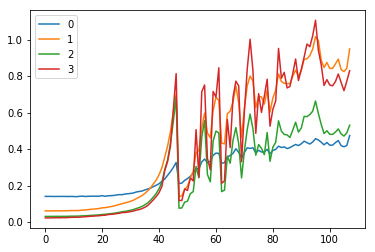

In [43]:
for h in hooks:
    plt.plot(h.means)
    h.remove()
plt.legend(range(4));

### A Hooks class

In [90]:
#export
from torch.nn import init

class Hooks():
    def __init__(self, ms, f): self.hooks = [Hook(m, f) for m in ms]
    def __getitem__(self,i): return self.hooks[i]
    def __len__(self): return len(self.hooks)
    def __iter__(self): return iter(self.hooks)
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
        
    def remove(self):
        for h in self.hooks: h.remove()

In [91]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, lr=0.5)

In [101]:
x,y = next(iter(data.valid_dl))
x = mnist_resize(x).cuda()

In [102]:
x.mean(),x.std()

(tensor(-0.0127, device='cuda:0'), tensor(0.9849, device='cuda:0'))

In [103]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2131, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4124, device='cuda:0', grad_fn=<StdBackward0>))

In [104]:
for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight)

In [105]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4773, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0452, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.49044203125, tensor(0.4927, device='cuda:0')]
valid: [0.6361658203125, tensor(0.8141, device='cuda:0')]


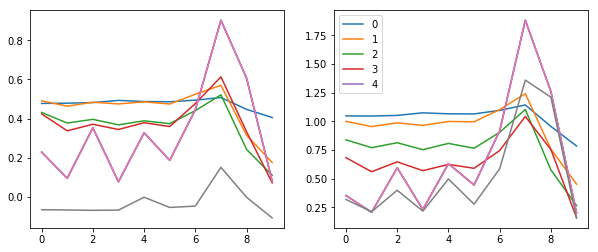

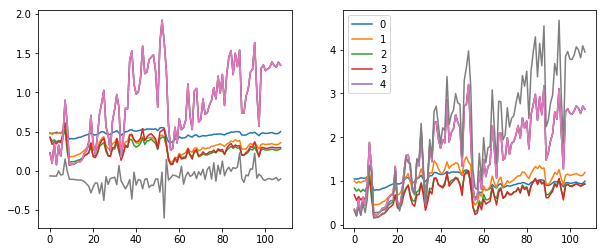

In [106]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ax0.plot(h.means)
        ax1.plot(h.stds)
    plt.legend(range(5));

## Generalized ReLU

In [92]:
#export
def get_cnn_layers(data, nfs, **kwargs):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs, **kwargs): return nn.Sequential(*get_cnn_layers(data, nfs, **kwargs))

def conv2d(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [93]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))

for l in model:
    if isinstance(l, nn.Sequential): init.kaiming_normal_(l[0].weight, a=0.1)

learn,run = get_runner(model, lr=0.1)

train: [1.1993634375, tensor(0.6680, device='cuda:0')]
valid: [0.47515673828125, tensor(0.8759, device='cuda:0')]


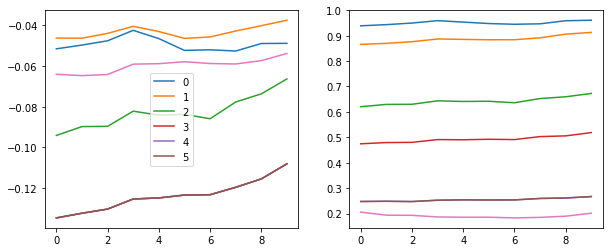

In [94]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));

In [182]:
def init_cnn(m):
    for l in m:
        if isinstance(l, nn.Sequential):
            init.kaiming_normal_(l[0].weight, a=0.1)
            l[0].weight.data.mul_(1.1)

In [183]:
model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
init_cnn(model)
learn,run = get_runner(model, lr=0.1)

train: [1.088340859375, tensor(0.7068, device='cuda:0')]
valid: [0.47598212890625, tensor(0.8756, device='cuda:0')]


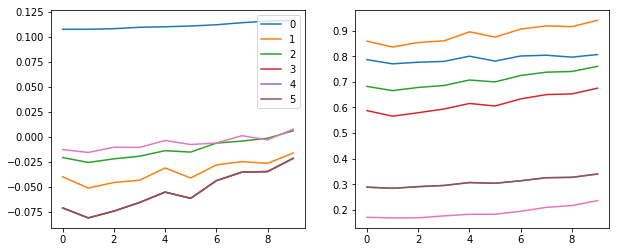

In [184]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))

with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    for h in hooks:
        ax0.plot(h.means[:10])
        ax1.plot(h.stds[:10])
    h.remove()
    ax0.legend(range(6));

In [257]:
def get_learn_run(nfs, lr, cbs=None):
    model =  SequentialModel(*get_cnn_layers(data, nfs, leak=0.1, sub=0.4, maxv=6.))
    init_cnn(model)
    return get_runner(model, lr=lr, cbs=cbs)

In [258]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.2, 1.), sched_lin(1., 0.1)]) 

In [259]:
learn,run = get_learn_run([8, 16, 32, 64], 1., cbs=ParamScheduler('lr', sched))

In [188]:
run.fit(8, learn)

train: [0.788958828125, tensor(0.7592, device='cuda:0')]
valid: [0.2636699951171875, tensor(0.9237, device='cuda:0')]
train: [0.22712306640625, tensor(0.9305, device='cuda:0')]
valid: [0.1691684814453125, tensor(0.9485, device='cuda:0')]
train: [0.16426267578125, tensor(0.9499, device='cuda:0')]
valid: [0.10736746826171875, tensor(0.9679, device='cuda:0')]
train: [0.09078033203125, tensor(0.9729, device='cuda:0')]
valid: [0.08951355590820312, tensor(0.9733, device='cuda:0')]
train: [0.0713287744140625, tensor(0.9786, device='cuda:0')]
valid: [0.0769127197265625, tensor(0.9777, device='cuda:0')]
train: [0.0581701171875, tensor(0.9830, device='cuda:0')]
valid: [0.072382470703125, tensor(0.9786, device='cuda:0')]
train: [0.050179658203125, tensor(0.9855, device='cuda:0')]
valid: [0.06867281494140624, tensor(0.9796, device='cuda:0')]
train: [0.0447371826171875, tensor(0.9883, device='cuda:0')]
valid: [0.0665090576171875, tensor(0.9799, device='cuda:0')]


## Export

In [1]:
!python notebook2script.py 06_cuda_cnn_hooks_init.ipynb

Converted 06_cuda_cnn_hooks_init.ipynb to nb_06.py
